# ExploringTemporalData
**Eli Simic Robertson**

In [4]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install networkx

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
from pprint import pprint
import random
import networkx as nx 
import matplotlib.pyplot as plt 
import collections

# deprecation warnings
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

In [14]:
'''Need source for code
'''

class GraphVisualization: 
   
    def __init__(self): 
          
        # visual is a list which stores all  
        # the set of edges that constitutes a 
        # graph 
        self.visual = [] 
          
    # addEdge function inputs the vertices of an 
    # edge and appends it to the visual list 
    def addEdge(self, a, b): 
        temp = [a, b] 
        self.visual.append(temp) 
          
    # In visualize function G is an object of 
    # class Graph given by networkx G.add_edges_from(visual) 
    # creates a graph with a given list 
    # nx.draw_networkx(G) - plots the graph 
    # plt.show() - displays the graph 
    def visualize(self): 
        G = nx.Graph() 
        G.add_edges_from(self.visual) 
        nx.draw_networkx(G) 
        plt.show() 
  

## Generating My Own Data

In [15]:
body_constr = [0,20]
head_constr = [0,10]
max_root_time = 100000 - head_constr[1]

# BODY_CONST = 'body'
HEAD_CONST = 'head'
ROOT_CONST = 'root'
A = 'a'
always = 100

In [16]:
def time_interval(body_constr): return tuple(np.random.uniform(body_constr)) 

def unique_body_symbols(low=3, high=5, single=False):
    '''Creates a random unique list of symbols for the body 
    of pattern. Symbol A has been excluded from the list as it is reserved 
    for the head of the pattern.
        Args: 
            n_body_symbols (int): amount of body symbols
            
        Returns:
            random_symbols (list): random choice of symbols
    '''
    symbols = ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k'] # possible body symbols
    n_bod_symbols = np.random.randint(low, high)
    if single:  n_bod_symbols = 1 
    rand_symbols = random.sample(symbols, k=n_bod_symbols)
    
    return rand_symbols

def make_edges(Edge, body_symbols, condition=None, connected_nodes=None):
    '''Args:
            Edge (named_tuple): Edge object with default fields.
            body_symbols (list): unique body symbols.
            condition (str/logical???): Conditional operator, if any.
            connected_nodes (list): list of currently connected nodes to 
            graph object.
        Returns:
            edges (list of named_tuples): 
            connected_nodes (list): 
            
    '''
    
    if condition == 'conjunction' or condition == 'disjunction':
        n_body_symbols = 2
    elif condition == 'negation' or condition == 'cycle':
        n_body_symbols = 1
    elif condition == None:
        n_body_symbols = len(body_symbols)
    
    edges = []
    if connected_nodes is None: connected_nodes = []
    
    for _ in range(n_body_symbols):
        sym = body_symbols.pop()
        start_t, end_t = time_interval(body_constr)
        rand_end_s = np.random.choice(connected_nodes + [ROOT_CONST])        

        if condition == 'disjunction':
            edges.append(Edge(ROOT_CONST, sym, start_t, end_t, prob=always, disjunction=True))
            connected_nodes.append(sym)
        elif condition == 'conjunction':
            edges.append(Edge(ROOT_CONST, sym, start_t, end_t, prob=always, conjunction=True))
            connected_nodes.append(sym)
        elif condition == 'negation':
            edges.append(Edge(rand_end_s, sym, start_t, end_t, prob=always, negation=True))
            connected_nodes.append(sym)
        elif condition == 'cycle':
            edges.append(Edge(rand_end_s, sym, start_t, end_t, prob=always, cycle=True))
            connected_nodes.append(sym)
        # no conditional operator, append edge to connected nodes or root
        elif condition == None:
            edges.append(Edge(rand_end_s, sym, start_t, end_t, prob=always))
            connected_nodes.append(sym)

    return edges, connected_nodes

def body_pattern(low_body=4, high_body=6, low_prob=60, high_prob=90, disjunction=False,
                   negation=False, conjunction=False, prob=always, cycle=False):
    
    body_symbols = unique_body_symbols(low_body, high_body) # technically, body_symbols excluding root
    rand_num = np.random.uniform(low=0, high=always)
    prob = np.random.uniform(low=low_prob, high=high_prob)
    connected_nodes = ['root'] # keep track of connected nodes for end_symbol possibilities
    
    pattern = [] # pattern list of edges : graph like object
    fields = ('start_s', 'end_s', 'start_t', 'end_t', 'disjunction', 'negation', 'conjunction', 'cycle', 'prob')
    Edge = collections.namedtuple('Edge', fields)
    Edge.__new__.__defaults__ = (False,) * len(Edge._fields) # set default fields

        
    if disjunction:
        
        max_disjs = len(body_symbols) // 2
        print('max_disjs',max_disjs)
        n_disjs = np.random.randint(low=1, high=max_disjs)
        print(n_disjs)
        for disj in range(n_disjs): 
            edges, nodes = make_edges(Edge, body_symbols, condition='disjunction')
            pattern.append(Edge(nodes[0], nodes[1], # disjunction edge
                start_t=None, end_t=None, disjunction=True, prob=always))
            pattern.extend(edges)
            connected_nodes.extend(nodes)

    if cycle:
        edges, nodes = make_edges(Edge, body_symbols, condition='cycle') # create cycle edge
        pattern.append(Edge(nodes[0], np.random.choice(connected_nodes),
                           disjunction=True)) # create disjunction edge to stop infinite loop
        pattern.extend(edges)
        connected_nodes.extend(nodes) 
        
    elif negation:
        edges, nodes = make_edges(Edge, body_symbols, condition='negation',
                                 connected_nodes=connected_nodes)
        pattern.extend(edges)
        connected_nodes.extend(nodes) 
        
    elif conjunction:
        edges, nodes = make_edges(Edge, body_symbols, condition='conjunction')
        pattern.extend(edges)
        connected_nodes.extend(nodes)
    # remaining nodes are added to either root or connected body node
    edges, nodes = make_edges(Edge, body_symbols, condition=None,
                             connected_nodes=connected_nodes)
    pattern.extend(edges)
    connected_nodes.extend(nodes)

    return pattern

def plot_pattern(pattern): # sometimes returns None? unsure why. annoying
    G = GraphVisualization() 
    for p in pattern: G.addEdge(p.start_s, p.end_s) 
    G.visualize()

## Visualisations of Reference Patterns (disregarding time dimension).

### Example of Disjunction
##### Notice how connected nodes now can connect to existing disjunction

max_disjs 3
2
[Edge(start_s='d', end_s='i', start_t=None, end_t=None, disjunction=True, negation=False, conjunction=False, cycle=False, prob=100),
 Edge(start_s='root', end_s='d', start_t=0.0719290525304257, end_t=3.1980436384671584, disjunction=True, negation=False, conjunction=False, cycle=False, prob=100),
 Edge(start_s='root', end_s='i', start_t=0.58745441662221, end_t=14.461840433403673, disjunction=True, negation=False, conjunction=False, cycle=False, prob=100),
 Edge(start_s='h', end_s='j', start_t=None, end_t=None, disjunction=True, negation=False, conjunction=False, cycle=False, prob=100),
 Edge(start_s='root', end_s='h', start_t=0.09719557849428317, end_t=12.98392457046384, disjunction=True, negation=False, conjunction=False, cycle=False, prob=100),
 Edge(start_s='root', end_s='j', start_t=0.8070568206682526, end_t=1.5228248631316177, disjunction=True, negation=False, conjunction=False, cycle=False, prob=100),
 Edge(start_s='root', end_s='f', start_t=0.7412549380165743, end_t

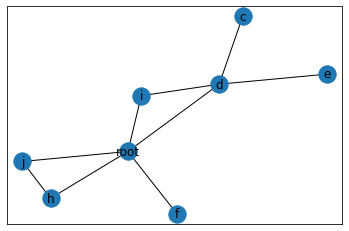

max_disjs 3
1
[Edge(start_s='h', end_s='i', start_t=None, end_t=None, disjunction=True, negation=False, conjunction=False, cycle=False, prob=100),
 Edge(start_s='root', end_s='h', start_t=0.40686014668947224, end_t=10.416099901834773, disjunction=True, negation=False, conjunction=False, cycle=False, prob=100),
 Edge(start_s='root', end_s='i', start_t=0.7699932783863149, end_t=13.785754733622744, disjunction=True, negation=False, conjunction=False, cycle=False, prob=100),
 Edge(start_s='root', end_s='k', start_t=0.5164353698196222, end_t=13.340290834619928, disjunction=False, negation=False, conjunction=False, cycle=False, prob=100),
 Edge(start_s='i', end_s='b', start_t=0.9504906209097853, end_t=14.688052593715122, disjunction=False, negation=False, conjunction=False, cycle=False, prob=100),
 Edge(start_s='h', end_s='f', start_t=0.032547147506394314, end_t=15.842316324080763, disjunction=False, negation=False, conjunction=False, cycle=False, prob=100),
 Edge(start_s='f', end_s='j', sta

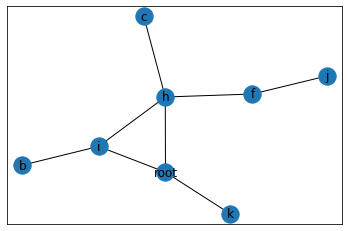

In [17]:
for _ in range(2): 
    ref_pattern = body_pattern(low_body=6, high_body=8, disjunction=True)
    pprint(ref_pattern)
    plot_pattern(ref_pattern)

### Example of Negation

[Edge(start_s='root', end_s='b', start_t=0.4698817738136073, end_t=16.519907605587218, disjunction=False, negation=True, conjunction=False, cycle=False, prob=100), Edge(start_s='b', end_s='e', start_t=0.7014473259265498, end_t=14.810534391878242, disjunction=False, negation=False, conjunction=False, cycle=False, prob=100), Edge(start_s='root', end_s='f', start_t=0.9566205564195575, end_t=13.023071416540978, disjunction=False, negation=False, conjunction=False, cycle=False, prob=100), Edge(start_s='root', end_s='d', start_t=0.5355766159843358, end_t=18.297719249301284, disjunction=False, negation=False, conjunction=False, cycle=False, prob=100)]


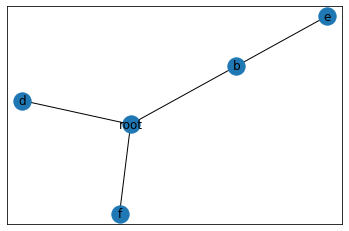

[Edge(start_s='root', end_s='c', start_t=0.9260390583192099, end_t=10.143160221013323, disjunction=False, negation=True, conjunction=False, cycle=False, prob=100), Edge(start_s='root', end_s='b', start_t=0.897961114096722, end_t=18.81474216988477, disjunction=False, negation=False, conjunction=False, cycle=False, prob=100), Edge(start_s='c', end_s='d', start_t=0.06509649632039005, end_t=3.509812361397234, disjunction=False, negation=False, conjunction=False, cycle=False, prob=100)]


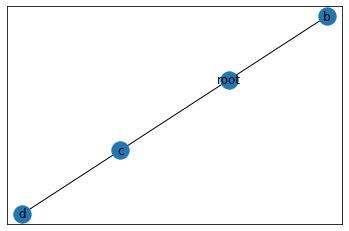

[Edge(start_s='root', end_s='c', start_t=0.9260390583192099, end_t=10.143160221013323, disjunction=False, negation=True, conjunction=False, cycle=False, prob=100),
 Edge(start_s='root', end_s='b', start_t=0.897961114096722, end_t=18.81474216988477, disjunction=False, negation=False, conjunction=False, cycle=False, prob=100),
 Edge(start_s='c', end_s='d', start_t=0.06509649632039005, end_t=3.509812361397234, disjunction=False, negation=False, conjunction=False, cycle=False, prob=100)]

In [18]:
for _ in range(2): 
    ref_pattern = body_pattern(low_body=3, high_body=5, negation=True)
    print(ref_pattern)
    plot_pattern(ref_pattern)

ref_pattern

### Example of Conjunction

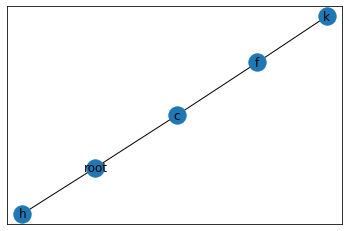

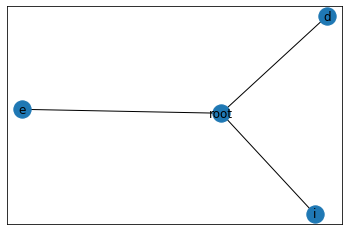

In [19]:
# Raised the low threshold to be able to perform both operators.
for _ in range(2): 
    ref_pattern = body_pattern(low_body=3, high_body=6, conjunction=True, prob=None)
    plot_pattern(ref_pattern)

### Example of Cycle

[Edge(start_s='c', end_s='root', start_t=False, end_t=False, disjunction=True, negation=False, conjunction=False, cycle=False, prob=False),
 Edge(start_s='root', end_s='c', start_t=0.269950080226829, end_t=12.28741079857974, disjunction=False, negation=False, conjunction=False, cycle=True, prob=100),
 Edge(start_s='c', end_s='f', start_t=0.05858599151108601, end_t=15.917799670556473, disjunction=False, negation=False, conjunction=False, cycle=False, prob=100)]


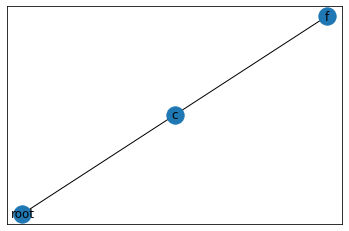

[Edge(start_s='d', end_s='root', start_t=False, end_t=False, disjunction=True, negation=False, conjunction=False, cycle=False, prob=False),
 Edge(start_s='root', end_s='d', start_t=0.7984986666484478, end_t=18.79424868992585, disjunction=False, negation=False, conjunction=False, cycle=True, prob=100),
 Edge(start_s='root', end_s='k', start_t=0.5435357170627082, end_t=10.764905889299154, disjunction=False, negation=False, conjunction=False, cycle=False, prob=100)]


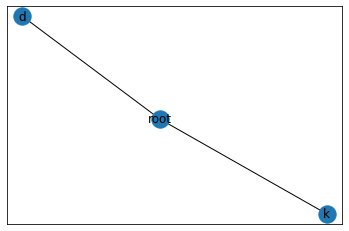

In [20]:
# Raised the low threshold to be able to perform both operators.
for _ in range(2): 
    ref_pattern = body_pattern(low_body=2, high_body=3, cycle=True)
    pprint(ref_pattern)
    plot_pattern(ref_pattern)

## Generating Training Set
<br>

method that generates a relative time point to it's neighbouring symbol. 

Input: Node Edge(start_s= , tp)

Output: (list) Absolute time points of neighboring symbols

if Cycle also create a disjunction edge of two existing nodes



if 



```
[Edge(start_s='e', end_s='root', start_t=0.09076355834009453, end_t=14.146677014691154, disjunction=False, negation=False, conjunction=False, cycle=False, prob=100),
 Edge(start_s='f', end_s='e', start_t=0.9788685189371282, end_t=17.247531396840778, disjunction=False, negation=False, conjunction=False, cycle=False, prob=100)]
```



```
loop over edges:
    node_t = foo(edge.start_s, timepoint(l, h))
    
    find all nodes ending in node_t
    
    calculate time diff


```

Do we need to store the values. 
    

In [21]:
def time_point(start_t, end_t): return np.random.uniform(start_t, end_t)

def outgoing_edges(node, pattern):
    '''Find all edges that that end in a node'''
    source_node = None
    nodes = {}
    for edge in pattern:
        if edge.disjunction and edge.start_t is None: 
            continue
            
        elif edge.negation == True: continue # skip negation node        
            
        elif edge.end_s == node and edge.start_t != None:
            source_node = edge.start_s
            nodes[edge.end_s] = time_point(edge.start_t, edge.end_t)

    return source_node, nodes



tps = {'root': np.random.uniform(low=0, high=100)}

def foo():
    for e in patt:
        source_node, end_node = outgoing_edges(e.end_s, patt)
        print(source_node, end_node)

        if source_node in tps:
            print(True)
            tps[end_node] = tps[source_node] - end_node

#         else:
#             foo()
            
    print(tps)

foo()


f {'k': 0.0}
root {'g': 9.571213315161847}
True


TypeError: unsupported operand type(s) for -: 'float' and 'dict'

max_disjs 3
2
[Edge(start_s='b', end_s='d', start_t=None, end_t=None, disjunction=True, negation=False, conjunction=False, cycle=False, prob=100),
 Edge(start_s='root', end_s='b', start_t=0.9106766143058498, end_t=16.310390043942256, disjunction=True, negation=False, conjunction=False, cycle=False, prob=100),
 Edge(start_s='root', end_s='d', start_t=0.6780324032567995, end_t=15.604849558380351, disjunction=True, negation=False, conjunction=False, cycle=False, prob=100),
 Edge(start_s='c', end_s='j', start_t=None, end_t=None, disjunction=True, negation=False, conjunction=False, cycle=False, prob=100),
 Edge(start_s='root', end_s='c', start_t=0.6008177197266401, end_t=2.7046392717219483, disjunction=True, negation=False, conjunction=False, cycle=False, prob=100),
 Edge(start_s='root', end_s='j', start_t=0.3304457724788349, end_t=14.504632577194005, disjunction=True, negation=False, conjunction=False, cycle=False, prob=100),
 Edge(start_s='b', end_s='h', start_t=0.6569802246293179, end_t=

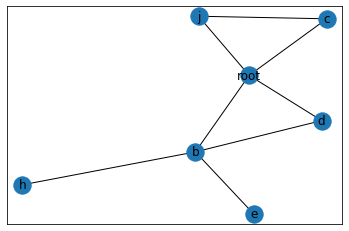

In [29]:
patt = body_pattern(low_body=3, high_body=7, disjunction=True)
pprint(patt)

plot_pattern(patt)

In [30]:
def time_point(start_t, end_t): return np.random.uniform(start_t, end_t)

def generate_edge_instance(tp,edge):
    return tp - time_point(edge.start_t, edge.end_t), edge.end_s

def outgoing_edges(node, pattern):
    '''Find immediate edges for a node'''
    out_edges = []
    for edge in pattern:            
        if edge.disjunction and edge.start_t is None: continue
            
        elif edge.negation == True: continue # skip negation node        
            
        elif edge.start_s == node:            
            out_edges.append(edge)

    return out_edges

def dest_nodes(node,pattern):
    out_edges = outgoing_edges(node,patt)
    return [edge.end_s for edge in out_edges]
    
def mutual_excl_edges(pattern):
    '''Find all mutually exclusive edges in pattern'''
    return [e for e in pattern if e.start_t == None]

def have_mutual(node, excl_edges):
    '''Is a given node connected to a mutually exclusive node'''
    for edge in excl_edges:
        if node == edge.start_s or node == edge.end_s:
            return True
        
    else: False
        
def generate_neighbouring_tps(node,tp,patt):
    out_edges = outgoing_edges(node,patt)
    excl_edges = mutual_excl_edges(patt)

    # determine which edge to choose from each mutual exclusion
    skip_nodes = []
    for edge in excl_edges:
        if np.random.randint(2) == 1:
            skip_nodes.append(edge.start_s)
        else:
            skip_nodes.append(edge.end_s)

    tps = []
    for edge in out_edges:
        if edge.end_s in skip_nodes: continue
        tps.append(generate_edge_instance(tp,edge))
        
    return tps
        
        
def generate_tps(node,tp,patt):
    all_tps = []

    if node == None:
        # this is the start of recursive generation, start from root
        node = 'root'
        tp = np.random.uniform(low=0, high=max_root_time)
        all_tps += (node,tp)
    
    neighbouring_tps = generate_neighbouring_tps(node,tp,patt)
    all_tps += neighbouring_tps
    
    print('neighbouring_tps from',node)
    pprint(neighbouring_tps)
    
    for neighbouring_tp in neighbouring_tps:
        # recursive step (because calling this same method)
       all_tps += generate_tps(neighbouring_tp[1],neighbouring_tp[0],patt)

    print('all_tps from',node)
    pprint(all_tps)
    
    return all_tps

    

    


In [35]:
# notice the order of generation from the print statements
generate_tps(None,None,patt)

neighbouring_tps from root
[(47282.36867211062, 'd'), (47287.12720757478, 'j')]
neighbouring_tps from d
[]
all_tps from d
[]
neighbouring_tps from j
[]
all_tps from j
[]
all_tps from root
['root', 47291.30930200308, (47282.36867211062, 'd'), (47287.12720757478, 'j')]


['root', 47291.30930200308, (47282.36867211062, 'd'), (47287.12720757478, 'j')]

In [ ]:
def abs_time_points():
    tps = {'root': np.random.uniform(low=0, high=100000)} 
    for edge in pattern:
        out_edges = outgoing_edges(edge.start_s, pattern)
        
        tps[edge.end_s] = 

In [ ]:
# def foo():
#     '''Starts at random edge in an instance of a Pattern. Iteratively find edges 
#     '''
#     ref_dict = {}
#     rand_idx = np.random.randint(low=0, high=len(patt)) # choose random edge to start on
#     rand_edge = patt[rand_idx]

#     if 'root' not in ref_dict: ref_dict['root'] = np.random.uniform(low=0, high=100) 
#     pprint(patt)
#     for edge in patt:
#         ref_dict = nieghbouring_tps(edge, ref_dict)
#         print(ref_dict)
    
# foo()

In [ ]:
# for i in patt:
#     nieghbouring_tps(patt[i].start_s, node_tp, patt)
            


#             print(True)
#             if edge.start_s in ref_dict: return # time point for node already in dict
    
#             elif edge.end_s in ref_dict:
#                 time_diff = ref_dict[edge.end_s] - time_point(edge.start_t, edge.end_t)
#                 ref_dict[edge.start_s] = time_diff
#                 return ref_dict
#             else:
#                 return ref_dict
            
#         if edge.start_t == None: continue # skip disjunction edge

#         elif edge.disjunction:
#             d_count += 1
#             if which_d == d_count: # pop one of the disjunctions
#                 patt.pop(patt.index(edge))

#         elif edge.negation == True: continue # skip negation node

#         elif edge.cycle == True: pass

#         elif edge.end_s not in node_tps: continue # skip edges that end in a symbol that doesn't exist in the instance

#         node_tps[edge.start_s] = node_tps[edge.end_s] - time_point(edge.start_t, edge.end_t)

In [ ]:
# for edge in patt:
#     tp = time_point(edge.start_t, edge.end_t)
    
    
def nieghbouring_tps(patt, s_tp, reference_tps):
    tps = [[end_s, tp]] # add initial node and time
    for e in patt: 
        if e.end_s == end_s:
            abs_tp = tp - time_point(e.start_t, e.end_t)
            tps.append([e.start_s, abs_tp])
            
    if len(tps) == 1: return None

    else: return tps

def foo():
    # end case if no further nodes 
    tps = {}
    
    for edge in pattern:
        if edge.end_s == 'root':
            root_tp = np.random.uniform(low=0, high=1000)
            nieghbouring_tps(nieghbouring_tps(patt, edge.end_s, tp=root_tp))
        else:
            pass
            
                
        
    
                       
pprint(patt)
nieghbouring_tps(patt, edge.end_s, np.random.uniform(low=0, high=1000))
# print(plot_pattern(patt))

In [ ]:
plot_pattern(patt)

In [ ]:
np.random.seed(42)

time_point(1, 2)

In [ ]:
patt = body_pattern(low_body=4, high_body=5, disjunction=True)

pprint(patt)
print(plot_pattern(patt))

def time_point(start_t, end_t): return np.random.uniform(start_t, end_t)

root_tp = np.random.uniform(low=0, high=100)

node_tps = {'root': root_tp} # look-up dictionary for node time points

d_count = 0 # enumerate disjunctions

### NOTE: this will always generate which_d = 1 because 'high' boundary is not inclusive
which_d = np.random.randint(low=1, high=2) # choose either first or second disjunction

for edge in patt:
    if edge.start_t == None: continue # skip disjunction edge
    
    elif edge.disjunction:
        d_count += 1
        if which_d == d_count: # pop one of the disjunctions
            patt.pop(patt.index(edge))
    
    elif edge.negation == True: continue # skip negation node
        
    elif edge.cycle == True: pass

    elif edge.end_s not in node_tps: continue # skip edges that end in a symbol that doesn't exist in the instance
    
    node_tps[edge.start_s] = node_tps[edge.end_s] - time_point(edge.start_t, edge.end_t)

node_tps

In [65]:
def time_point(start_t, end_t): return np.random.uniform(start_t, end_t)

def create_instance(patt, time_high=100000, make_pred=False): 
    '''
    Returns:
        ts (list): list of lists of time point and symbol adhereing
        to pattern definition'''
    
    ts = [] # empty time series list
    pred = []

    root_tp = time_point(start_t=0, end_t=time_high)
    head_prob = np.random.uniform(low=60, high=90)
    
    if make_pred: # if pattern instance create pred for .pred file
        start_t, end_t = time_interval(head_constr)    
        head_tp = root_tp + time_point(start_t, end_t)
        pred.append([head_tp, A])
    
        if np.random.uniform(low=0, high=100) > head_prob: # whether pattern has consequent 
            ts.append([head_tp, A])

    rand_num = np.random.uniform(low=0, high=100)

    disjs = []
    for edge in patt:
        if edge.start_t is None: # mutual exclusion edge case
            continue

        elif edge.disjunction == True and make_pred == True:
            disjs.append(edge)

        elif edge.conjunction: # already done, as all edges 
            pass 

        elif edge.cycle: 
            
            if rand_num > 0.5:
                for cyc in range(2):
                    ts.append([root_tp - time_point(edge.start_t, edge.end_t), edge.start_s])

            ## INSERT LOGIC: repeat subset or entire pattern, need for mutual exclusion 
            # if just setting threshold , e.g cycle_iters above???

        elif edge.negation: # skip negation node
            continue

        else:# for non-conditional edges  
            ts.append([root_tp - time_point(edge.start_t, edge.end_t), edge.start_s])

    if len(disjs) > 1: # if there are multiple disjunctions, randomly choose one for .event
        disj = disjs[np.random.randint(low=0, high=len(disjs) - 1)] 
        ts.append([root_tp - time_point(disj.start_t, disj.end_t), disj.start_s])
    
    # create root in ts if it isn't empty pattern (edge case when subset retrurns empty subset, e.g [])
    if patt == []: 
        return ts
    elif make_pred:
        ts.append([root_tp, ROOT_CONST])
        return ts, pred
    else:
        return ts # when a random subset, return only ts


## Making Noise!

**Time Series Consists of: **<br>
- Singular Pattern replicated over time line
- Random Subsets of the Pattern (func: rand_subset)
- Individual Noisy Symbols

Insert logic to insert the negation into the instance at equal prob

In [9]:
def rand_subset(pattern): # random subset of the instance
    '''
    Returns:
        ts (list): list of lists of time point and symbol of
        random subset of the pattern definition'''
    subset_idxs = sorted([np.random.randint(low=0, high=len(pattern)) for _ in range(2)])
    sub_pattern = pattern[subset_idxs[0]: subset_idxs[1]]
    
    return sub_pattern
    
def noisy_instance(time_high=100000):
    ''' Input: 
            time_high (int): 
    
            Returns:
                ts (list): list of lists containing random time point and symbol'''
    
    sym = unique_body_symbols(single=True).pop()
    tp = time_point(start_t=0, end_t=time_high)
    inst = [[tp, sym]]
    return inst




def create_outputs(pattern, n_patterns, n_subsets, n_noisy_insts):
    '''Creates both .event array and its corresponding .pred array from
    
    
    Returns:
            events (list): time series for training/testing set
            preds (list): ground truth values
    '''

    
    events, preds = [], []
    
    for _ in range(n_patterns):
        event, pred =  create_instance(patt, make_pred=True)
        events.extend(event)
        preds.extend(pred)
        
    for _ in range(n_subsets):
        event = create_instance(rand_subset(patt))
        if event != []:
            events.extend(event)
        else:
            continue
        
    for _ in range(n_noisy_insts):
        event = noisy_instance()
        events.extend(event)
    
    events.sort(key=lambda x: x[0])
    preds.sort(key=lambda x: x[0])# sort by timestamp
    
    return events, preds
    


## Output to file.

In [12]:
patt = body_pattern(low_body=4, high_body=6, low_prob=60, high_prob=90,
             disjunction=False, negation=False, conjunction=False, prob=100, cycle=False)

events, preds = create_outputs(patt, n_patterns=100, n_subsets=500, n_noisy_insts=500)

In [11]:
events[:5]

NameError: name 'events' is not defined

In [21]:
preds[:5]

[[797.8172557714969, 'a'],
 [1269.9456051485674, 'a'],
 [1317.8180656423028, 'a'],
 [1702.6484827812483, 'a'],
 [2623.3561186172683, 'a']]

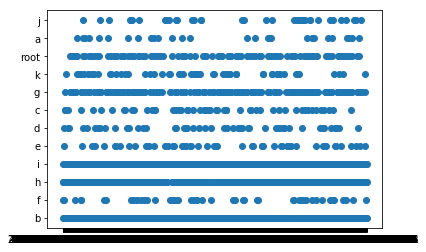

In [13]:
X = np.array(events)

values = list(X[:, 1])
names = list(X[:, 0])
plt.figsize(20,20)
plt.scatter(names, values);
plt.show()

In [34]:
with open('n_patterns_100_n_subsets_500_n_noisy_insts_500.event', 'w') as file:
    for l in events:
        s = str(l[0]) + ' ,' + str(l[1]) + '\n'
        file.write(s)

## LMK what you think :)

**Concerns:**<br>
- disjunction and conjunction always connect to root node fist, do we need to have a pattern where it would be prepended to another connected node

- Don't use the mutual exclusion edge

- cycles